一.MNIST的数据预处理

1.这里数据的导入部分和之前的一样，唯一不同的是数据集的reshape部分。因为这次使用的是卷积神经网络来提取特征进行识别（卷积神经网络部分可参考网上其它博客，有很多教程），卷积网络因为必须先进行卷积与池化运算，所以必须保持图像的维数。

2.导入相关第三方库

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import time

3.读取MNIST的手写数据

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

4.将图像转为4维矩阵，使其满足卷积神经网络输入要求，其中第一维为batch_size，第二维第三维为图片大小，第四维为图片通道数，因为这里的图像是单色灰度图像，所以值为1，如果是彩色图像，则为3。



In [3]:
#shape[0]代表的就是batch_size
x_train4D = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
x_test4D = x_test.reshape(x_test.shape[0],28,28,1).astype('float32')

5.对图像进行进行标准化，使取值范围在[0,1]之间。

In [4]:

x_train4D_normalize = x_train4D/255.0
x_test4D_normalize = x_test4D/255.0

6.对图像标签进行One-Hot编码（独热编码）。



In [5]:
y_trainOneHot = tf.keras.utils.to_categorical(y_train)
y_testOneHot = tf.keras.utils.to_categorical(y_test)

二.模型的搭建

1.建立Sequential线性堆叠模型。

In [6]:
#建立线性堆叠模型
model = tf.keras.models.Sequential()

2.模型结构：

2层卷积层（提取特征）+2层最大池化层（减小图片大小）+1层Dropout层（防止过拟合）+1层平坦层（将提取的所有特征转为一维向量）+ 两层全连接层。

这里蛮提一下池化的作用：/ 减少需要处理的图像数据点，减少运算时间  / 减少图片之间位置的差异 / 参数量减少有益于控制过拟合。

Dropout层主要为了防止过拟合，具体内容上一节有提到。

而平坦层Flatten则是将卷积池化后的所有特征转化为一维向量，以便于神经网络可以输入。

In [7]:
#filter等于是滤镜，对原图像提取生成16个的特征图像，比如有的滤镜是提取边缘，有的提取的是别的特征。kernel_size则是卷积核大小，padding='same'的意思是，卷积层的输出大小与原图像大小一样，用0值补全。
model.add(layers.Conv2D(filters=16,kernel_size=(5,5),padding='same',input_shape=(28,28,1),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2))) #最大池化，此时图像大小为14x14
model.add(layers.Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2))) #此时图像大小为7x7
model.add(layers.Dropout(0.3)) #使百分30的神经元失活
model.add(layers.Flatten()) #转一维向量输入
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.5)) #使百分50神经元失活
model.add(layers.Dense(10,activation='softmax'))

3.模型概要查看

In [8]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

三.模型的训练

1.相关参数设置及训练，具体参数意义可参照上节内容。

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

t_start = time.time()
train_history = model.fit(x=x_train4D_normalize,y=y_trainOneHot,validation_split=0.2,epochs=5,batch_size=300,verbose=2)
t_end = time.time()
print ("time cost: %5.2f ms" % ((t_end - t_start) * 1000))    #毫秒级时间戳

Epoch 1/5
160/160 - 2s - loss: 0.5174 - accuracy: 0.8356 - val_loss: 0.1046 - val_accuracy: 0.9669
Epoch 2/5
160/160 - 1s - loss: 0.1372 - accuracy: 0.9587 - val_loss: 0.0651 - val_accuracy: 0.9797
Epoch 3/5
160/160 - 1s - loss: 0.1010 - accuracy: 0.9697 - val_loss: 0.0519 - val_accuracy: 0.9833
Epoch 4/5
160/160 - 1s - loss: 0.0845 - accuracy: 0.9749 - val_loss: 0.0426 - val_accuracy: 0.9866
Epoch 5/5
160/160 - 1s - loss: 0.0708 - accuracy: 0.9785 - val_loss: 0.0435 - val_accuracy: 0.9874
time cost: 9157.83 ms


2.查看参数保存内容。

In [10]:
print(train_history.history)

{'loss': [0.5173778533935547, 0.13722874224185944, 0.10098016262054443, 0.08445588499307632, 0.07077037543058395], 'accuracy': [0.835645854473114, 0.9586666822433472, 0.9696875214576721, 0.9749166369438171, 0.9785208106040955], 'val_loss': [0.10460387170314789, 0.0650903508067131, 0.051857512444257736, 0.04257763549685478, 0.04354076087474823], 'val_accuracy': [0.9669166803359985, 0.9796666502952576, 0.9832500219345093, 0.9865833520889282, 0.987416684627533]}


3.调用上节编写的show_train_history函数查看曲线变化。


In [11]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train]) #绘制训练数据的执行结果
    plt.plot(train_history.history[validation]) #绘制验证数据的执行结果
    plt.title('Train History') #图标题 
    plt.xlabel('epoch') #x轴标签
    plt.ylabel(train) #y轴标签
    plt.legend(['train','validation'],loc='upper left') #添加左上角图例

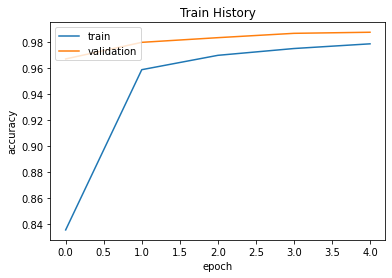

In [12]:
show_train_history(train_history,'accuracy','val_accuracy')

四.模型的预测

1.用测试集进行预测。

In [13]:
scores = model.evaluate(x_test4D_normalize,y_testOneHot)
print(scores[1])
prediction = model.predict_classes(x_test4D_normalize)
print(prediction[:10]) #显示前10个数字预测结果

313/313 [==============================] - 1s 3ms/step - loss: 0.0351 - accuracy: 0.9886

2.调用pandas的混淆矩阵查看结果。

In [14]:
pd.crosstab(y_test,prediction,rownames=['label'],colnames=['predict'])


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,976,0,0,0,0,0,0,1,3,0
1,0,1131,2,1,0,0,0,1,0,0
2,3,0,1025,0,0,0,0,4,0,0
3,0,0,1,1002,0,3,0,2,2,0
4,0,0,2,0,976,0,0,1,0,3
5,2,0,0,5,0,879,2,1,1,2
6,7,3,0,0,5,2,936,0,5,0
7,0,1,6,1,0,0,0,1019,1,0
8,5,1,1,1,1,0,0,3,958,4
